# Data analysis

To play with the data, we need to have a configured [experiment](../../_autosummary/caqtus.extension.Experiment.rst#Experiment) with its storage location set.

Here we will use a SQLite database that already contains some data.
It can be downloaded [here](https://github.com/light-scattering-io/caqtus/blob/main/doc/source/tutorials/notebooks/database.zip?raw=true).
You will need to unzip it and put it in the same folder as this notebook.

If you have already set up your experiment, you can also use it instead.

In [1]:
from caqtus.extension import Experiment
from caqtus.session.sql import SQLiteConfig

experiment = Experiment()
experiment.configure_storage(SQLiteConfig("database.db"))

## Storage session

A fist concept is the *storage session*. To talk to the database that contains your data, you must be inside a with block like this:

In [2]:
with experiment.storage_session() as storage:
    # Put the code that read from the database here
    ...

At the beginning of the block, the experiment will connect to the database.
The code inside the block is executed, and finally the connection is closed. 

Whenever you want to interact with the place the data is stored, you will need a block like this.

If sometimes you get an error like "session is not active", it is probably because you are not in a block like this.


## Sequence

When we are in the with block, we can use the storage object to find a [sequence](../../_autosummary/caqtus.session.Sequence.rst#Sequence) that was run.

This sequence contains all the information that you edited in condetrol and the data generated when it was run.

Below we find a sequence that was run and we print some information about it.


In [3]:
with experiment.storage_session() as storage:
    sequence = storage.get_sequence(r"\scan mot current")

    print(f"Sequence '{sequence}' is in state '{sequence.get_state()}'")
    print(f"It was started at this date: {sequence.get_start_time()}")

Sequence '\scan mot current' is in state 'finished'
It was started at this date: 2024-09-10 16:25:55.417559+00:00


Note that the sequence object is only valid inside the with block.
If you try to use it outside the block, you will get an error:

In [4]:
sequence.get_start_time()

ExperimentSessionNotActiveError: Experiment session is not active and cannot be used

## Shots

A sequence that was launched contains [shots](../../_autosummary/caqtus.session.Shot.rst#Shot).
Each shot corresponds to a given set of parameters and contains the data associated to these parameters.

Once we have a sequence, it is possible to get its shots like this:

In [5]:
with experiment.storage_session() as storage:
    sequence = storage.get_sequence(r"\scan mot current")
    shots = list(sequence.get_shots())

    print(f"Sequence '{sequence}' has {len(shots)} shots")

Sequence '\scan mot current' has 180 shots


From a shot we can get the parameters used to run it and the data produced:

In [6]:
with experiment.storage_session() as storage:
    sequence = storage.get_sequence(r"\scan mot current")
    shots = list(sequence.get_shots())

    shot = shots[75]

    parameters = shot.get_parameters()
    data = shot.get_data()

### Shot parameters

The format of the `parameters` object is a dictionary where the keys are the parameter names and the values are the parameter values.

In [7]:
# Here we print all the parameters of the shot 75
for name, value in parameters.items():
    print(f"{name}: {value}")

mot_loading.duration: 50.0 millisecond
mot_loading.current: 2.796610169491525 ampere
mot_loading.x_current: 0.2542372881355932 ampere
mot_loading.y_current: 0.305 ampere
mot_loading.z_current: 0.085 ampere
mot_loading.blue_power: 1.0
mot_loading.blue_frequency: 23.728813559322035 megahertz
mot_loading.red_frequency: -3.2542372881355934 megahertz
mot_loading.red_power: 0.0 decibel
mot_loading.push_power: 0.7 milliwatt
imaging.power: -18.0 decibel
imaging.frequency: -18.23 megahertz
imaging.exposure: 30.0 millisecond
imaging.x_current: 0.25 ampere
imaging.y_current: 4.94 ampere
imaging.z_current: 0.183 ampere
red_mot.ramp_duration: 100.0 millisecond
red_mot.x_current: 0.28176271186440677 ampere
red_mot.x_current_1: 0.27 ampere
red_mot.x_current_2: 0.32 ampere
red_mot.y_current: 0.09584745762711865 ampere
red_mot.z_current: 0.027627118644067805 ampere
red_mot.current: 0.8 ampere
red_mot.power: -36.0 decibel
red_mot.frequency: -1.05 megahertz
red_mot.duration: 100.0 millisecond
collisions.

A specific value can be accessed from the parameters like this: 

In [8]:
current = parameters["mot_loading.x_current"]
current

<Quantity(0.254237288, 'ampere')>

Some values like the current above are `Quantity` objects with magnitude and units.
Each field of the `Quantity` object can be accessed like this:

In [9]:
current.magnitude, current.units

(0.2542372881355932, <Unit('ampere')>)

### Shot data

The `data` object is a dictionary that maps data label to their values:

In [10]:
# Here we only print the labels of the data
for label in data.keys():
    print(label)

Orca Quest\picture
Orca Quest\background
shot analytics


We can get a specific data by its label.
For example, the image `Orca Quest\picture` is a blurry and not centered picture of a MOT.

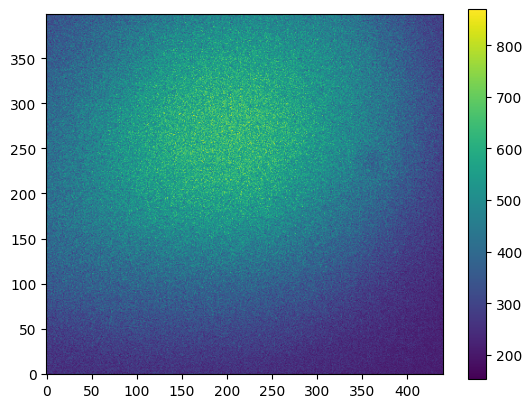

In [11]:
image = data[r"Orca Quest\picture"]

import matplotlib.pyplot as plt

plt.imshow(image.T, origin="lower")
plt.colorbar()

Knowing how to read parameters and data from a shot, we can now in principle do all the analysis we want:

Text(0, 0.5, 'Fluorescence')

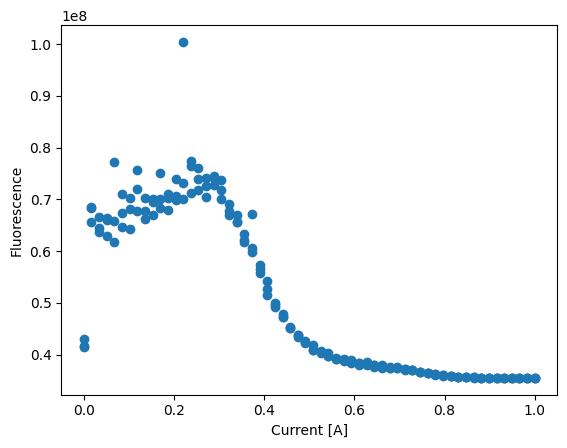

In [12]:
currents = []
fluos = []

with experiment.storage_session() as storage:
    sequence = storage.get_sequence(r"\scan mot current")
    shots = sequence.get_shots()

    for shot in shots:
        parameters = shot.get_parameters()
        current = parameters["mot_loading.x_current"].magnitude

        data = shot.get_data()
        image = data[r"Orca Quest\picture"]
        fluo = image.sum()

        currents.append(current)
        fluos.append(fluo)

plt.plot(currents, fluos, "o")
plt.xlabel("Current [A]")
plt.ylabel("Fluorescence")

## Dataframes

While it is possible to do all the analysis like the above, it can become cumbersome quickly.

If you want to average the fluorescence for each current, you will need to group shots with the same currents and then average the values.

Things can become even more complicated if you want to do more complex operations.

To reduce the pain, it is possible to extract the data from the shots into *dataframes* and then use the *polars* library to do the heavy lifting.

For this, you will need to write a function that transforms a shot into a dataframe:

In [13]:
import polars as pl

from caqtus.session import Shot


def extract_dataframe(shot: Shot) -> pl.DataFrame:
    parameters = shot.get_parameters()
    data = shot.get_data()

    current = parameters["mot_loading.x_current"].magnitude
    image = data[r"Orca Quest\picture"]
    fluo = image.sum()

    return pl.DataFrame({"current": [current], "fluo": [fluo]})

Now we can use the function on a single shot to obtain a dataframe:

In [14]:
with experiment.storage_session() as storage:
    sequence = storage.get_sequence(r"\scan mot current")

    shot = next(sequence.get_shots())

    df = extract_dataframe(shot)
df

current,fluo
f64,u64
0.0,42980280


By concatenating the dataframes of all shots, we can obtain a dataframe that contains the data for the full sequence:

In [15]:
with experiment.storage_session() as storage:
    sequence = storage.get_sequence(r"\scan mot current")

    shots = sequence.get_shots()

    df = pl.concat(extract_dataframe(shot) for shot in shots)

df

current,fluo
f64,u64
0.0,42980280
0.016949,65690609
0.033898,63727100
0.050847,66366509
0.067797,77280214
…,…
0.932203,35504541
0.949153,35494083
0.966102,35505373


On this dataframe, we can then use all the power of the polars library to do the analysis we want:

Text(0, 0.5, 'Fluorescence')

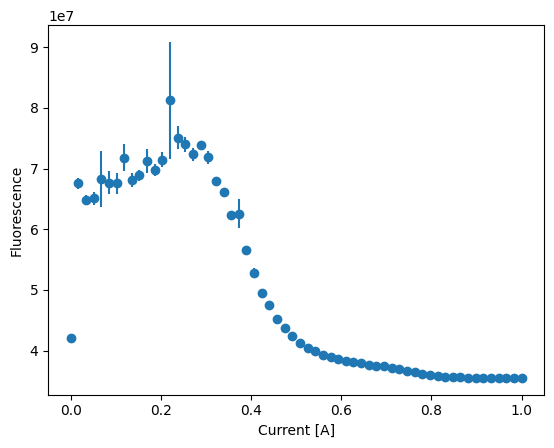

In [16]:
averaged = df.group_by("current").agg(
    mean=pl.mean("fluo"), error=pl.std("fluo") / pl.Expr.sqrt(pl.count("fluo"))
)

plt.errorbar(averaged["current"], averaged["mean"], yerr=averaged["error"], fmt="o")
plt.xlabel("Current [A]")
plt.ylabel("Fluorescence")

### Predefined shot-to-dataframe functions


With this approach, you will still need to write the function that transforms a shot into a dataframe.

Fortunately, some of these function are already implemented in the [caqtus.analysis.loading](../../_autosummary/caqtus.analysis.loading.rst) module.

For example, the [LoadShotParameters](../../_autosummary/caqtus.analysis.loading.LoadShotParameters.rst#LoadShotParameters) function extracts the parameters of a shot into a dataframe:

In [17]:
from caqtus.analysis.loading import LoadShotParameters

# This is a function that extracts the parameters of the shot
extract_shot_parameters = LoadShotParameters()

with experiment.storage_session() as storage:
    sequence = storage.get_sequence(r"\scan mot current")

    shot = next(sequence.get_shots())

    df = extract_shot_parameters(shot)

df

exposure,mot_loading.x_current,rep
struct[2],struct[2],f64
"{30.0,""ms""}","{0.0,""A""}",0.0


Or the [LoadImageCount](../../_autosummary/caqtus.analysis.loading.LoadImageCount.rst#LoadImageCount) function sums the pixels of an image and puts it in a dataframe:

In [18]:
from caqtus.analysis.loading import LoadImageCount

# This is a function that extracts the count of the image
extract_image_count = LoadImageCount("Orca Quest", "picture", "background")

with experiment.storage_session() as storage:
    sequence = storage.get_sequence(r"\scan mot current")

    shot = next(sequence.get_shots())

    df = extract_image_count(shot)

df

picture count
u64
7673299


The functions defined in the [caqtus.analysis.loading](../../_autosummary/caqtus.analysis.loading.rst)  module have also the possibility to be combined.

By using the `+` operator between two such functions, we can create a new function that extracts both information from the shot:

In [19]:
sum_function = extract_shot_parameters + extract_image_count

with experiment.storage_session() as storage:
    sequence = storage.get_sequence(r"\scan mot current")

    shot = next(sequence.get_shots())

    df = sum_function(shot)
df

exposure,mot_loading.x_current,rep,picture count
struct[2],struct[2],f64,u64
"{30.0,""ms""}","{0.0,""A""}",0.0,7673299


Putting it all together, we can load the data of the sequence like this:

In [20]:
loader = LoadShotParameters() + LoadImageCount("Orca Quest", "picture")

with experiment.storage_session() as storage:
    sequence = storage.get_sequence(r"\scan mot current")

    shots = sequence.get_shots()

    df = pl.concat(loader(shot) for shot in shots)
df

exposure,mot_loading.x_current,rep,picture count
struct[2],struct[2],f64,u64
"{30.0,""ms""}","{0.0,""A""}",0.0,42980280
"{30.0,""ms""}","{0.016949,""A""}",0.0,65690609
"{30.0,""ms""}","{0.033898,""A""}",0.0,63727100
"{30.0,""ms""}","{0.050847,""A""}",0.0,66366509
"{30.0,""ms""}","{0.067797,""A""}",0.0,77280214
…,…,…,…
"{30.0,""ms""}","{0.932203,""A""}",4.0,35504541
"{30.0,""ms""}","{0.949153,""A""}",4.0,35494083
"{30.0,""ms""}","{0.966102,""A""}",4.0,35505373


And plot the values like this:


Text(0, 0.5, 'Fluorescence')

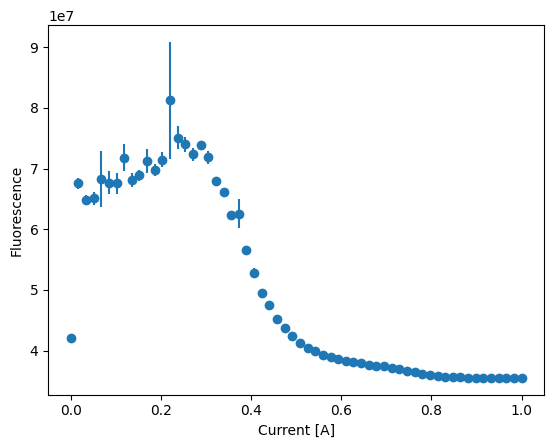

In [21]:
averaged = (
    df.with_columns(pl.col("mot_loading.x_current").quantity.magnitude())
    .group_by("mot_loading.x_current")
    .agg(
        mean=pl.mean("picture count"),
        error=pl.std("picture count") / pl.Expr.sqrt(pl.count("picture count")),
    )
)

plt.errorbar(
    averaged["mot_loading.x_current"], averaged["mean"], yerr=averaged["error"], fmt="o"
)
plt.xlabel("Current [A]")
plt.ylabel("Fluorescence")